# **Sea Level Acceleration: Station Exploration**

Written by Bailey Armos and Chris Zervas - [bailey.armos@noaa.gov](bailey.armos@noaa.gov) and [chris.zervas@noaa.gov](chris.zervas@noaa.gov)

Coastal Hazards Branch  
Oceanographic Division  
NOAA's Center for Operational Oceanographic Products and Services (CO-OPS)

Last updated on: 4/30/2024

## Overview
NOAA's Center for Operational Oceanographic Products and Services (CO-OPS) is the nation's source for [coastal inundation data and sea level trends](https://tidesandcurrents.noaa.gov/sea_level_info.html) through its network of long-term water level gauges. In this notebook, we will review, plot, and perform statisical analysis on past local sea level data and explore future trajectories. This notebook will walk through how [sea level trends](https://tidesandcurrents.noaa.gov/sltrends/faq.html#q2) are calculated and how different graphics that are part of CO-OPS Sea Level Trends product are produced.

This notebook is designed to explore a single station. Users can choose their station of interest here: [Sea Level Trends Map](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html).

For this example we will use [Pensacola, FL (8729840)](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8729840).

## Prerequisites and running the Notebook
This notebook uses Python programming and users may run it either in **Google Colab** or **Jupyter Notebook**. To work offline, manage libraries and dependencies personally; using **Jupyter Notebook** is recommeended. If you want cloud-based instant access, seamless co-operation and have access to good internet connection, **Google Colab** is the best option.

This notebook is designed so that people with limited familiarity with Python can run the notebook. To do so, go to the [github](https://github.com/NOAA-CO-OPS/Coastal_Hazards_Example_Notebooks) page and click on the drop down menu under 'Code', then download the ZIP file. Extract the ZIP file and upload the Sea_Level_Rise_Station_Exploration_Notebook into [google colab](https://colab.research.google.com/). [Explore different station/s](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html) and change the station variable and unit of interest in step 3. Lastly, click **Runtime** in the top menu and choose **Run All**. Then, when the 'Choose Files' box in step 2 becomes active, click on it and upload the TR_local_projections.csv and Station_ID_lookup.csv. You will see a green check mark to the left of each cell as cells are sucessfully executed.

Users should be prepared to commit 1-2 hours to familiarize themselves with the notebook, upload data, run code and examine results.

## Learning Outcomes
In this notebook users will be able to:
  1.  Explore historical sea level data,
  2.  Learn how CO-OPS calculates long-term Relative Sea Level (RSL) trends with acceleration, and
  3.  Examine future SL trajectories, scenarios, and background relative sea level trends (showing the influence of processes including vertical land motion (VLM))

## Data Source and Documentations
Input and output documentation can be found in the [CO-OPS Data API](https://api.tidesandcurrents.noaa.gov/api/prod/), [CO-OPS Derived Product API v0.1](https://api.tidesandcurrents.noaa.gov/dpapi/prod/) and the [CO-OPS Metadata API](https://api.tidesandcurrents.noaa.gov/mdapi/prod/).

Standard templates are available within the [CO-OPS API URL Builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html), but this notebook is designed to give you more flexiblity through building our own API template to generate queries from our Data API, MetaData API, and Derived Product API.

All data used for this notebook come from the CO-OPS API, except for the gauge-based trajectory data from the [2022 Sea Level Rise (SLR) Technical Report](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report.html) which can be accessed [here](https://zenodo.org/records/6067895). A csv file that has been extracted from the netcdf is included with this notebook.


## Software
This tutorial uses the following Python packages:
- datetime
- requests
- time
- pandas
- numpy
- matplotlib
- seaborn
- cmocean
- statsmodels
- warnings

## Run each of the 'code' cells in order.  They are indicated  by the white triangle in the black circles or by [  ] at the beginning of the cell.

# **Step 1**
## Install and Load Packages
Lets check if you have these packages installed. If not, this cell will install them.

In [1105]:
# @title
import subprocess, sys
packages = ["datetime","requests","time","pandas","numpy","matplotlib","seaborn","statsmodels","warnings"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now we load our packages and assign them names to use throughout the notebook.

In [1106]:
# @title
import datetime as dt
import requests
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
import warnings
#comment the line below if using Jupyter Notebook
from google.colab import files
#this is to suppress user warnings
warnings.filterwarnings("ignore")

# **Step 2**
## Upload External Data
Here we will upload the Local observations, projections and trajectories (TR_local_projections.csv) data from the 2022 Sea Level Rise (SLR) Technical Report  and Station ID lookup (Station_ID_lookup.csv) file that will be used in step 8.

These files can be found on the CO-OPS [Github](https://github.com/NOAA-CO-OPS) page in the Coastal_Hazards_Example_Notebooks repository with this notebook.

In [1107]:
# @title
uploaded = files.upload()

# **Step 3**
## Here we choose the station ID of interest and unit of measurement you would like to use, i.e. 'english' (feet) or 'metric' (meter)
Click [here](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html) to see a map of stations to get Station IDs

- Note that stations with limited data in the [National Tidal Datum Epoch (NTDE)](https://tidesandcurrents.noaa.gov/datum_options.html) 1983-2001 will not work in this notebook


### The stations with the longest periods of record (greater than 95 years) are:
|Station ID and Name  | Station ID and Name | Station ID and Name|
|:--------------------|:--------------------|:--------------------|
|1612340	Honolulu, HI	| 8574680	Baltimore, MD	| 8771450	Galveston, TX |
|1617760	Hilo, HI	| 8575512	Annapolis, MD	| 9410170	San Diego, CA |
|8410140	Eastport, ME	|	8594900	Washington, DC	| 9410230	La Jolla, CA|
|8418150	Portland, ME	|	8638610	Sewells Point, VA	| 9410660	Los Angeles, CA|
|8443970	Boston, MA	| 8665530	Charleston, SC	| 9414290 San Francisco, CA|
|8452660	Newport, RI	| 8720030	Fernandina Beach, FL | 9439040	Astoria, OR|
|8518750	The Battery, NY	|	8724580	Key West, FL| 9447130	Seattle, WA|
|8534720	Atlantic City, NJ	|	8727520	Cedar Key, FL | 9450460	Ketchikan, AK|
|8557380	Lewes, DE	| 8729840	Pensacola, FL| 9451600	Sitka, AK |




In [1108]:
#input station ID below
station = '8729840'

#options are metric or english
units = 'metric'

### Results will be in Meters and Millimeters/Year if 'metric' is chosen
### Results will be in Feet and Inches/Decade if 'english' is chosen

# **Step 4**
### Next, we pull in our data from the CO-OPS Data Product API





In [1109]:
# @title
#begin and end date can be adjusted

#some stations have a different pre-defined start date to work within this notebook
#eg: https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=19000101&end_date=20221231&station=8638610&product=monthly_mean&datum=msl&time_zone=gmt&units=english&format=json

#Seward, AK: removing data prior to earthquake https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=9455090
if station == '9455090':
    begin_date = "19640201"
# Redwood City, CA: Sporatic data prior to 1990 making it difficult to visualize the data
elif station == '9414523':
    begin_date = "19900101"
else:
  begin_date = "19000101"
end_date = "20231231"
product = "monthly_mean"
datum = "msl"
server = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?"

myurl = (server + "begin_date=" + begin_date +"&end_date=" + end_date +"&station=" + station +
         "&product=" + product +"&datum=" + datum + "&time_zone=gmt&units="+units+"&format=json")

# Use "requests" to get the Monthly MSL Data
urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
mydata = content['data']
mymeta= content['metadata']

station_name=mymeta['name']
station_id=mymeta['id']

# Make it a Dataframe
mydf = pd.DataFrame(mydata)

### Then we use another API to see what is the relative sea level (RSL) trend that is currently published on the CO-OPS website.  This trend is a combination of the rising ocean surface and the vertical land motion (VLM) at the site.

  [Table of Relative Sea Level Trends](https://tidesandcurrents.noaa.gov/sltrends/mslUSTrendsTable.html)

In [1110]:
# @title
#begin and end date can be adjusted
#https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/sealvltrends.json?station=8638610&affil=us
begin_date = "19000101"
end_date = "20231231"
product = "sealvltrends"
affil = "us"
server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/"

myurl = (server + product + ".json?station=" + station + "&affil=" + affil)

# Use "requests" to get the Monthly MSL Data
urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
mydata = content['SeaLvlTrends']

# Make it a Dataframe
mytrend = pd.DataFrame(mydata)

#Saving the station name and the start date of the station's data

station_info = mytrend['stationId'].iloc[0]+' '+mytrend['stationName'].iloc[0]
start_trend = pd.to_datetime(mytrend['startDate'].iloc[0])
# end_trend = pd.to_datetime(mytrend['endDate'].iloc[0])
end_trend = pd.to_datetime('12/31/2100')

#check out dataframe
mytrend

,stationId,stationName,affil,latitude,longitude,trend,trendError,units,startDate,endDate
0,8729840,"Pensacola, FL",US,30.4044,-87.211197,2.69,0.12,mm/yr,05/15/1923,12/15/2023


In [1111]:
# @title Below we retrieve datum epoch information
#grab datum info
server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/'

myurl = (server + station + '/datums.json?units='+units)

urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.
epoch_info = content['epoch']

#if we can't find the epoch info, default to NTDE
if epoch_info == '0000-0000':
  epoch_info = '1983-2001'

epic_start = int(epoch_info[0:4])
epic_end = int(epoch_info[5:])
epic_length = epic_end - epic_start
epic_mid = int((epic_start + epic_length/2))


# **Step 5**
# Data exploration and visualization

## Below we retrieve the MSL column which is the monthly mean sea level for the station, relative to the CO-OPS established MSL datum. Then we plot all the the MSL data.


      year  month    MSL day       date
0     1923      5 -0.029  01 1923-05-01
1     1923      6 -0.014  01 1923-06-01
2     1923      7 -0.111  01 1923-07-01
3     1923      8 -0.084  01 1923-08-01
4     1923      9 -0.020  01 1923-09-01
...    ...    ...    ...  ..        ...
1184  2023      8  0.190  01 2023-08-01
1185  2023      9  0.280  01 2023-09-01
1186  2023     10  0.298  01 2023-10-01
1187  2023     11  0.222  01 2023-11-01
1188  2023     12  0.131  01 2023-12-01

[1189 rows x 5 columns]


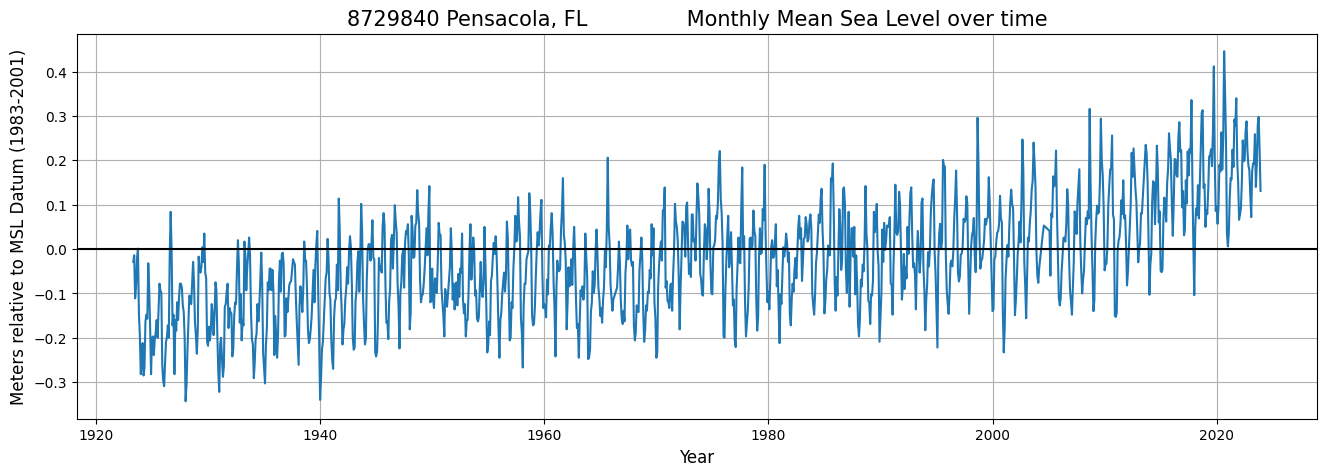

In [1112]:
# @title
#Focusing on the MSL
df_msl=mydf.loc[:,['year','month','MSL']]
#placeholder to represent each month
df_msl['day'] = '01'
df_msl['MSL'] = pd.to_numeric(df_msl['MSL'],downcast='float')
df_msl['year'] = df_msl['year'].astype('int')
df_msl['month'] = df_msl['month'].astype('int')
df_msl['date'] = pd.to_datetime(dict(year=df_msl.year,month=df_msl.month,day=df_msl.day))

fig, ax=plt.subplots(figsize=(16,5))
plt.plot(df_msl['date'],df_msl['MSL'])
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
else:
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
ax.set_title(station_info + 15*' ' + "Monthly Mean Sea Level over time",fontsize=15)
ax.axes.grid(True)
plt.axhline(0,color='black')

print(df_msl)


##What kind of variation can you see in the plot? Seasonal, interanual, long-term variability, trends? Do you see a rapid rise or fall or does the record look nearly flat? Can you estimate how much it has risen or fallen over the whole period of the record?

#**Step 6**
#**Exploring seasonal variations in water levels**
### We will focus on data from the NTDE from 1983-2001 for the next section.

#### What is the NTDE and why is it important?


*   The NTDE is a specific 19-year period used for data collection that corresponds to a full rotation of the longest lunar cycle called the metonic cycle which impacts the range and timing of tides.
*   Aligning the NTDE with the metonic cycle allows NOAA scientists to account for the full range of seasonal and environmental variations that occur at a given coastal location and determine the truest average of tidal conditions.
*   The NTDE is updated periodically to help ensure tidal datums accurately reflect conditions along the Nation's coast.
*   The NTDE time period is useful for examining shorter-term variations such as the seasonal cycle without the impact of long-term variations.

*** Some stations are more frequently updated due to high relative sea level trends

 The [2002 - 2020 NTDE](https://tidesandcurrents.noaa.gov/datum-updates/ntde/index.html) update is coming soon!

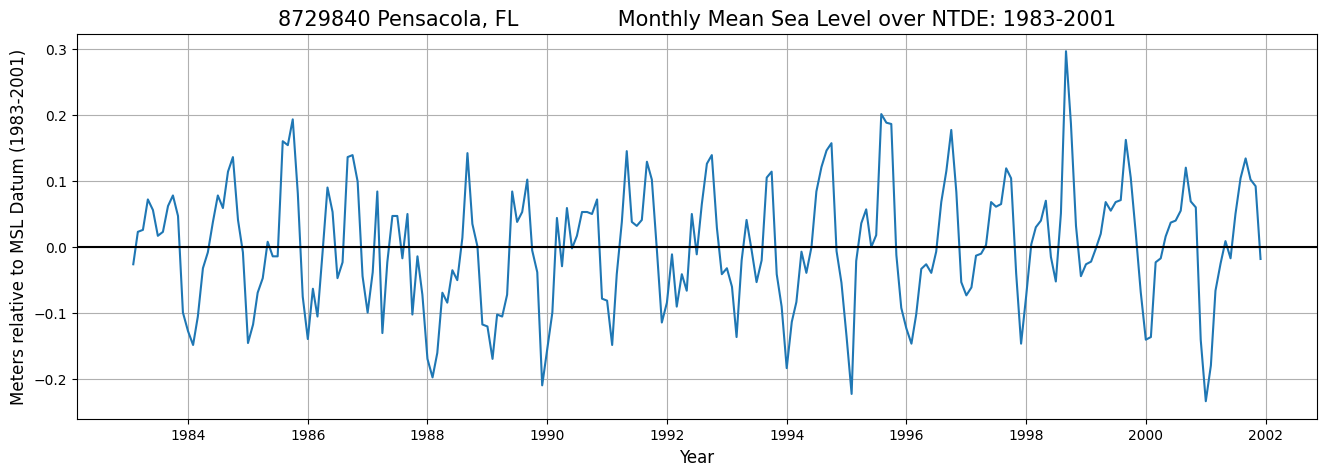

In [1113]:
# @title
start_date = '1983-01-01'
end_date = '2001-12-31'

mask = (df_msl['date'] > start_date) & (df_msl['date'] <= end_date)
df_ntde = df_msl.loc[mask]
df_ntde = pd.DataFrame(df_ntde)

fig, ax=plt.subplots(figsize=(16,5))
plt.plot(df_ntde['date'],df_ntde['MSL'])
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
else:
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
ax.set_title(station_info + 15*' ' + "Monthly Mean Sea Level over NTDE: "+epoch_info,fontsize=15)
ax.axes.grid(True)
plt.axhline(0,color='black')
#In this time frame it is harder to visualize the long-term trend, which is useful for examining the average seasonal cycle.

## Next, we can dive into the seasonal cycle.
### The average seasonal cycle of mean sea level is caused by regular fluctuations in coastal temperatures, salinities, winds, atmospheric pressures and ocean currents over time.  
### Which months will usually have the highest and  the lowest sea level over the average year at this station? What is the full range of the average seasonal cycle?

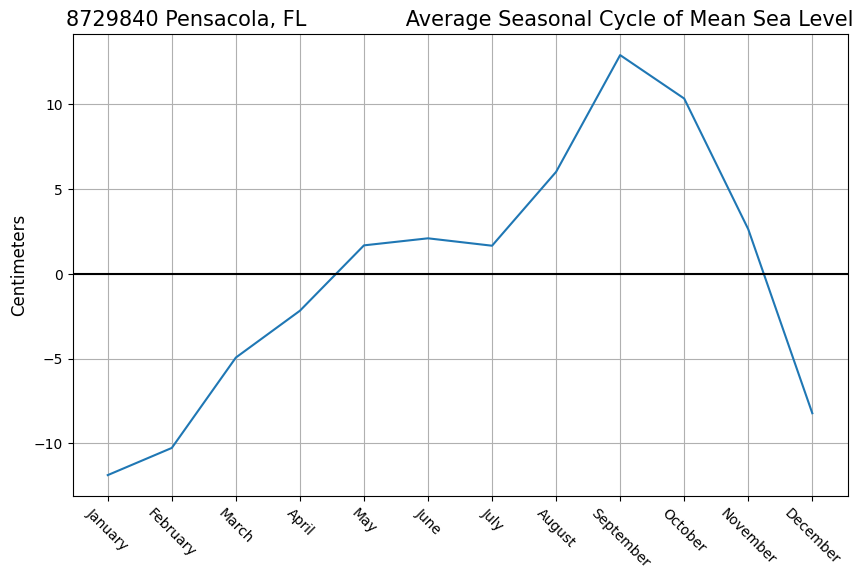

In [1114]:
# @title
#average seasonal over NTDE
monthly_ntde=df_ntde.groupby("month").mean(numeric_only=True)["MSL"]
df_msl = df_msl.set_index(df_msl.month)
df_msl['seasonal_msl'] = monthly_ntde
df_msl.set_index(df_msl.date,inplace=True)
msl_adjust = df_msl[['MSL']].copy()

#calculating monthly MSL with average seasonal cycle removed
msl_adjust['seasonal_msl'] = df_msl['seasonal_msl']
msl_adjust['msl_seasonal_adjust'] = msl_adjust['MSL']-df_msl['seasonal_msl']

if station in ['8737048','9414523','8570283','8720218']:
  print('station does not have enough data in NTDE to plot the average seasonal cycle')
else:
  fig, ax =plt.subplots(figsize=(10,6))
  if units == 'metric':
    ax.set_ylabel("Centimeters",fontsize=12)
    df_ntde['MSL_conv'] = df_ntde['MSL'] * 100
  else:
    ax.set_ylabel("Inches",fontsize=12)
    df_ntde['MSL_conv'] = df_ntde['MSL'] * 12
  ax.plot(df_ntde.groupby("month").mean(numeric_only=True)["MSL_conv"])
  ax.set_title(station_info + 15*' ' + "Average Seasonal Cycle of Mean Sea Level",fontsize=15)
  plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
             ,rotation=-45, fontsize = 10)
  ax.axes.grid(True)
  plt.axhline(0,color='black')

# **Step 7**

## **Long-term trends in relative water levels**

## Statistical analysis and plotting of long-term linear and hinged trends

#### Walking through the process of calculating the trends as seen in [CO-OPS Sea Level Trends Product](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html)

#### *** The trend calculations in this notebook may vary from the trend calculations on the website listed above.


*   The primary difference is that this notebook is in Python and the trends on the website are calculated using the R programing language. Python and R have different packages/libraries with different capabilities. It is expected to see some variations in using different languages/packages for running the Autoregressive Integrated Moving Average (ARIMA) model. The ARIMA model call and order in this notebook is the same as that run in R to produce the trends on the website, just with different packages/libraries.
*   The secondary difference is that on the website some stations have earlier data stored under previous station numbers and were combined to produce sea level trends (these were combined using a known relationship between the stations). This is not currently reflected in the CO-OPS Data API which only grabs data associated with the station number. In this notebook, these stations will produce trends for the data available in the API. For example, [Grand Isle](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8761724) on the website has data starting in 1947, but the station data on the API starts in 1978.

## Does the trend look linear or could it be accelerating or decelerating?  We will be searching for non-linearity of the trend in the next step.

# **Step 8**
## Incorporating future SL observation-based trajectories and scenario-based projections.

### First, we will add in the [2022 Sea Level Rise Technical Report](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report-sections.html) SL observation-based trajectories from data fit over 1970-2020 and extrapolated to 2050.  They were intended to provide a best estimate of the relative sea level change from 2020 to 2050 based on MSL data beginning in 1970, by solving for a linear trend with an added constant acceleration (quadratic) term.

#### As stated earlier, these trajectories are from the csv file with data extracted from the 2022 report (it is not available via API) that we uploaded at the beginning of the notebook.

In [1115]:
# @title
trajectories = pd.read_csv('TR_local_projections.csv')
lookup = pd.read_csv('Station_ID_lookup.csv')

#function to find the y-intercept based on the slope and acceleration of a curve that is at a level of y1 at year x1

def getYInt(x1, y1,slope,accel):
    y_intercept = accel*(x1*x1) + slope * (-x1) + y1
    return (y_intercept)

def bold(text):
  return "\033[1m" + text + "\033[0m"

print(bold("Number of months     " +str(len(msl_adjust))))
end_year_data = df_msl.year[-1]
print(bold('Data End Year = ' + str(end_year_data)))

# extend x axis to 2050 with yearly NaNs

df = pd.DataFrame({'date': ['2025-01-01','2026-01-01','2027-01-01','2028-01-01','2029-01-01','2030-01-01','2031-01-01','2032-01-01','2033-01-01',
                            '2034-01-01','2035-01-01','2036-01-01','2037-01-01','2038-01-01','2039-01-01','2040-01-01','2041-01-01','2042-01-01',
                            '2043-01-01','2044-01-01','2045-01-01','2046-01-01','2047-01-01','2048-01-01','2049-01-01','2050-01-01'
                            ,'2055-01-01','2060-01-01','2065-01-01','2070-01-01','2075-01-01','2080-01-01','2085-01-01','2090-01-01','2095-01-01','2100-01-01']})

df['MSL'] = np.nan
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
#msl_adjust = msl_adjust.append(df)
msl_adjust = pd.concat([msl_adjust, df])


#some stations have shorter trends due to events such as earthquakes that create an offset
#we can set our data to the post-earthquake time frame of the offical SL trend which we got from the derived data API

mask = (msl_adjust.index >= start_trend - dt.timedelta(days=15)) & (msl_adjust.index <= end_trend)
trend_timeframe = msl_adjust.loc[mask]
trend_timeframe = pd.DataFrame(trend_timeframe)
trend_timeframe['decimal_date']=trend_timeframe.index.year+(trend_timeframe.index.dayofyear -1)/365.

msl_adjust['day'] = '01'
msl_adjust['month'] = '01'
msl_adjust['year_date'] = pd.to_datetime(dict(year=msl_adjust.index.year,month=7,day=msl_adjust.day))
msl_adjust['annual_msl']=msl_adjust.groupby(by=msl_adjust.index.year)['msl_seasonal_adjust'].transform('mean')

Number of months     1189
Data End Year = 2023


In [1116]:
# @title
if station in ['9414523','9418767','8726384','8761927','8771510','8772447','8778490','8779748','8570283','8573927','8635027',
                '8411250','8419870','2695540','9455090','8737048']:
    print('No trajectories for this station')
else:
  station_lookup = lookup.loc[lookup['STATION_ID']==int(station)]
  psmsl_id = station_lookup['PSMSL_id'].values[0]
  if psmsl_id == -1:
    station_tg = station_lookup['Station_NAME_tg'].values[0]
    station_df = trajectories.loc[trajectories['tg']==station_tg]
  else:
    station_df = trajectories.loc[trajectories['PSMSL_id']==psmsl_id]
  station_df['day'] = '01'
  station_df['month'] = '07'

  pd.options.mode.chained_assignment = None
  station_df['date'] = pd.to_datetime(dict(year=station_df.years,month=station_df.month,day=station_df.day))
  station_df = station_df.set_index('date')

  if units == 'metric':
    #convert mm to m
    station_df['rsl_trajectory_m'] = station_df['rsl_trajectory']*0.001
    station_df['rsl_obs_m'] = station_df['rsl_obs']*0.001
  else:
    #convert mm to ft
    station_df['rsl_trajectory_m'] = station_df['rsl_trajectory']*0.00328084
    station_df['rsl_obs_m'] = station_df['rsl_obs']*0.00328084

  #for plotting with trajectories, they will need to be offset to center on 0.0 during the station's epoch
  epoch=station_df[str(epic_start):str(epic_end)]

  epoch_offset_m=np.nanmedian(epoch['rsl_trajectory_m'])

  if units == 'metric':
    print(bold("epoch_offset_m to put the trajectories on the station's MSL datum:  " + str(round(-epoch_offset_m,3)) + '   meters'))
  else:
    print(bold("epoch_offset_m to put the trajectories on the station's MSL datum:  " + str(round(-epoch_offset_m,2)) + '   feet'))

  station_df['rsl_trajectory_offset'] = station_df['rsl_trajectory_m'] - epoch_offset_m
  station_df['rsl_obs_offset'] = station_df['rsl_obs_m'] - epoch_offset_m

  median_df = station_df[station_df['percentiles']== 50]
  high_df = station_df[station_df['percentiles']== 83]
  low_df = station_df[station_df['percentiles']== 17]

epoch_offset_m to put the trajectories on the station's MSL datum:  0.028   meters


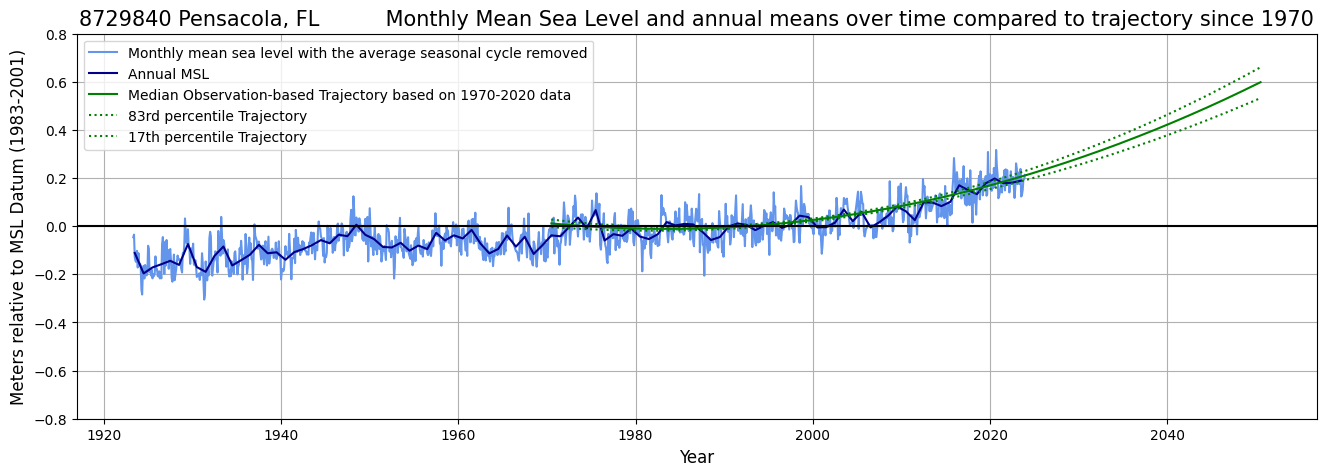

In [1117]:
# @title
fig, ax=plt.subplots(figsize=(16,5))
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
  if station in ['8771450','8638610','8729840','8594900','8727520']:
    plt.ylim(-0.8,0.8)
  else:
    plt.ylim(-0.6,0.6)
else:
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
  if station in ['8771450','8638610','8729840','8594900','8727520']:
    plt.ylim(-2.62,2.62)
  else:
    plt.ylim(-2,2)
ax.set_title(station_info + 10 * ' ' + 'Monthly Mean Sea Level and annual means over time compared to trajectory since 1970',fontsize=15)
ax.axes.grid(True)
plt.plot(msl_adjust['msl_seasonal_adjust'],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl'],color='darkblue',label='Annual MSL')
plt.plot(median_df.index,median_df['rsl_trajectory_offset'],color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
plt.plot(high_df.index,high_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='83rd percentile Trajectory')
plt.plot(low_df.index,low_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='17th percentile Trajectory')
plt.axhline(0,color='black')
plt.legend(loc='best')



# **Step 9**

### Now, lets use the entire MSL series to calculate our own linear trend with an added *quadratic acceleration* ['time1_sq'] term using an Autoregressive Integrated Moving Average (ARIMA) model.  This method is used by CO-OPS to calculate the linear trends on the [Relative Sea Level Trends](https://tidesandcurrents.noaa.gov/sltrends/mslUSTrendsTable.html) webpage.

This sub-section will walk through how the SL trends are calculated.

What is an ARIMA model?


*   AR - stands for auto-regression which includes equation terms created based on past data points
*   I - stands for integration or differencing which accounts for the overall trend in the data
*   MA - moving average which is the equation terms of error or noise based on past data points

ARIMA models are represented as ARIMA (p,d,q) where p, d, and q are all parameters that the user has to provide

*  p determines the number of autoregressive (AR) terms
*  d determines the order of differencing
*  q determines the number of moving average (MA) terms

For predicting our sea level trend, we are using the simplest ARIMA model
(p,d,q) = (1,0,0)

Click [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#) for documentation on the ARIMA model in python.

In [1118]:
# @title
accel_midyear=(msl_adjust.index.year[0]+msl_adjust.index.year[-36])/2
print('accel_midyear = ',accel_midyear)

#create matrix for ARIMA model, this is the format that the MSL data is in prior to the ARIMA model
matrix_data = pd.DataFrame()
matrix_data['time1']=trend_timeframe['decimal_date'] - end_year_data
matrix_data['time1_sq']=matrix_data['time1']*matrix_data['time1']
matrix_data['month']=trend_timeframe.index.month
matrix_data['msl']=trend_timeframe['MSL']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data

if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, we want in inches instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

accel_midyear =  1974.0
                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                 1225
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6332.814
Date:                Thu, 02 May 2024   AIC                          12699.629
Time:                        16:41:06   BIC                          12786.510
Sample:                             0   HQIC                         12732.323
                               - 1225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.2075      8.537     14.900      0.000     110.474     143.941
time1          4.4849      0.433     10.354      0.000       3.636       5.334
time1_sq       0.0182      0

In [1119]:
# @title
#get info from model
coefs=model_fit.params
se=model_fit.bse

#extracting our trend information from model
if units == 'metric':
  trend_text=str(end_year_data) + ' Trend : ' + str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  const_m = coefs[0]/1000
  slope_m = coefs[1]/1000
  error_m = (se[1]*1.96)/1000
  accel_text=str('Acceleration : '+ str(np.round(20*coefs[2],2))) +' +/- '+str(np.round(20*se[2]*1.96,2))+' mm/yr per decade'
  accel_m = coefs[2]/1000
  acc_error_m = (se[2]*1.96)/1000
else:
  trend_text=str(end_year_data) + ' Trend : ' + str(np.round(10*coefs[1],2)) +' +/- '+str(np.round(10*se[1]*1.96,2))+' inches/decade'
  const_m = coefs[0]/12
  slope_m = coefs[1]/12
  error_m = (se[1]*1.96)/12
  accel_text=str('Acceleration : '+ str(np.round(200*coefs[2],2))) +' +/- '+str(np.round(200*se[2]*1.96,2))+' inches/decade per decade'
  accel_m = coefs[2]/12
  acc_error_m = (se[2]*1.96)/12

print(bold(trend_text))
print(bold((accel_text)))
print(bold('Constant Acceleration since '+ str(np.datetime64(start_trend,'D'))))

2023 Trend : 4.48 +/- 0.85 mm/yr
Acceleration : 0.36 +/- 0.17 mm/yr per decade
Constant Acceleration since 1923-05-15


## Plotting the trend and 95% confidence bands around the regression line

In [1120]:
# @title
#if the station has an special 5-year epoch

#lin_y_int = getYInt(epic_mid-2020,0,slope_m,accel_m) #CZ  delete

if units == 'metric':
  print(bold('y-intercept at year ' + str(end_year_data) + ' relative to the MSL Datum: ' + str(round(const_m,3)) + '   meters'))
else:
  print(bold('y-intercept at year ' + str(end_year_data) + ' relative to the MSL Datum: ' + str(round(const_m,2)) + '   feet'))

#grabbing the months result from arima model
seasonal = coefs[2:14]
#calculating the mean seasonal and adding it to the trend line
seasonal = np.mean(seasonal)/1000
# calculating linear trend + acceleration
msl_adjust['accel_trend'] = accel_m*matrix_data['time1_sq'] + slope_m*matrix_data['time1'] + const_m
msl_adjust['accel_trend'] = msl_adjust['accel_trend']+seasonal
# manually calculate se of estimate
msl_adjust['y_y2']=(msl_adjust['msl_seasonal_adjust']-msl_adjust['accel_trend'])**2
y_y2_sum = msl_adjust['y_y2'].sum()
msl_adjust['se_regression']=np.sqrt(y_y2_sum/(len(msl_adjust)-2))

#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_adjust)
msl_adjust['decimal_date']=msl_adjust.index.year+(msl_adjust.index.dayofyear -1)/365
msl_adjust['x_x2'] = (msl_adjust['decimal_date']-msl_adjust['decimal_date'].mean())**2
msl_adjust['sum_x_x2'] = msl_adjust['x_x2'].sum()
msl_adjust['sqrt'] = np.sqrt(one_over_n+(msl_adjust['x_x2']/msl_adjust['sum_x_x2']))
msl_adjust['se_point'] = (msl_adjust['se_regression'])*msl_adjust['sqrt']

# get variance inflation factor (VIF)
p1 = coefs[-2]
VIF = ((1 + p1) / (1 - p1)) ** 0.5
# Calculate standard error of the regression line at each point
msl_adjust['se_point_vif'] = msl_adjust['se_point'] * VIF

#confidence bands
msl_adjust['upr'] = msl_adjust['accel_trend']+1.96*msl_adjust['se_point_vif']
msl_adjust['lwr'] = msl_adjust['accel_trend']-1.96*msl_adjust['se_point_vif']

y-intercept at year 2023 relative to the MSL Datum: 0.127   meters


## Now, we will plot our calculated trend with acceleration and compare it with the 1970-2020 trajectories



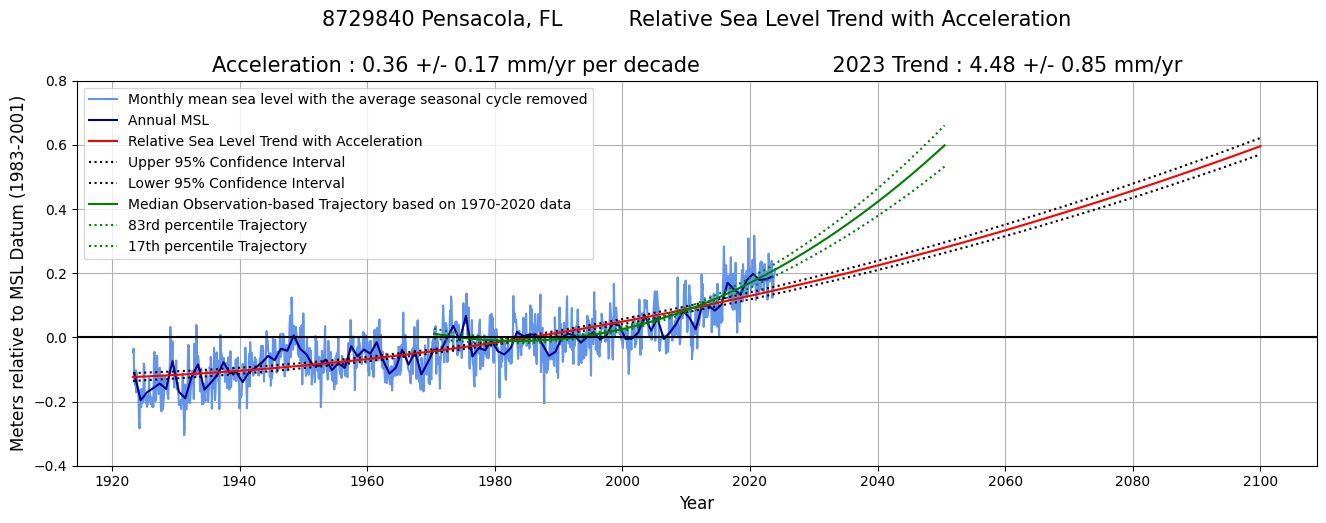

In [1121]:
# @title
fig, ax=plt.subplots(figsize=(16,5))
ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
  if station in ['8771450']:
    plt.ylim(-0.8,1.0)
  elif station in ['9451600']:
    plt.ylim(-0.8,0.8)
  else:
    plt.ylim(-0.4,0.8)
else:
  if station in ['8771450']:
    plt.ylim(-2.6,1.0)
  elif station in ['9451600']:
    plt.ylim(-2.6,3.3)
  else:
    plt.ylim(-1.3,2.6)
  ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl'],color='darkblue',label='Annual MSL')
plt.plot(msl_adjust.index,msl_adjust['accel_trend'],label='Relative Sea Level Trend with Acceleration ',color='red')
plt.plot(msl_adjust.index,msl_adjust['upr'],label='Upper 95% Confidence Interval',color='black',linestyle='dotted')
plt.plot(msl_adjust.index,msl_adjust['lwr'],label='Lower 95% Confidence Interval',color='black',linestyle='dotted')
plt.plot(median_df.index,median_df['rsl_trajectory_offset'],color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
plt.plot(high_df.index,high_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='83rd percentile Trajectory')
plt.plot(low_df.index,low_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='17th percentile Trajectory')
ax.axes.grid(True)
ax.set_title(station_info+ 10*' ' + 'Relative Sea Level Trend with Acceleration\n\n'+accel_text+ 20 *' ' + trend_text,fontsize=15)
plt.axhline(0,color='black')
plt.legend(loc='best')


## What trend type fits best?

### *For Pensacola, it can be seen that the calculated RSL trend (in red) based on data from the entire series 1923-2023, has a lower slope at 2020 than the trajectory based on the data from 1970-2020.  Given this trend's lower rate of acceleration over the whole series, by 2050 it reaches a level significantly below the calculated trajectory which began in 1970.  It doesn't reach the 2050 level of the trajectory until 2100.*

# **Step 10**

### Next, we can begin to explore some hinged trends where there is a linear trend up to a break point (hinge) at a specific date followed by a trend with acceleration after the break point. Hinged trends are especially useful for stations that appear to have accelerated recently like [Charleston, South Carolina](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8665530) or [Pensacola, Florida](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?id=8665530).

###The break point (hinge) can be set to any selected time point within the data record. We will start with a hinged point 50 years ago (January 1974).

*** Note that advanced users interested in more specific hinged points can simply change 1974 to a different year of choice.

In [1122]:
# @title
#here the user can change to a different hinge year
hinge_year=1974
hinge_date = str(hinge_year) + '-01-01'
msl_adjust['decimal_date']=msl_adjust.index.year+(msl_adjust.index.dayofyear -1)/365

In [1123]:
# @title
#For a hinged trend with acceleration, we need to adjust our input data matrix by making a time2 column that starts at the desired break point.
#The time1 column will be negative with zero at the breakpoint, and time2 column will be positive starting at the breakpoint.
# A trend2 squared column is added to solve for an acceleration parameter beginning after the break point

accel_midyear=(hinge_year+msl_adjust.index.year[-36])/2
print('accel_midyear = ',accel_midyear)

#create matrix for ARIMA model
matrix_data = pd.DataFrame()
matrix_data['time1']=trend_timeframe['decimal_date']
matrix_data['time1']=matrix_data['time1']- hinge_year
matrix_data['time2']=matrix_data['time1']
matrix_data.loc[matrix_data['time1']>0,'time1']=0
matrix_data.loc[matrix_data['time2']<0,'time2']=0
matrix_data['time2_sq']=matrix_data['time2']*matrix_data['time2']
matrix_data['month']=trend_timeframe.index.month
matrix_data['msl']=trend_timeframe['MSL']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data

if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, want in in instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

accel_midyear =  1999.5
                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                 1225
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6309.718
Date:                Thu, 02 May 2024   AIC                          12655.435
Time:                        16:41:08   BIC                          12747.428
Sample:                             0   HQIC                         12690.053
                               - 1225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.7367      6.226     -2.528      0.011     -27.939      -3.535
time1          2.6524      0.238     11.157      0.000       2.186       3.118
time2         -2.1294      0

In [1124]:
# @title
#Getting all the information from the model to plot the trendline and confidence bands
#finding the trend break
trend_break = msl_adjust.loc[msl_adjust.index==hinge_year]

coefs=model_fit.params
se=model_fit.bse

if units == 'metric':
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  se_accel = (se[2]**2  + (2 * (end_year_data-hinge_year)*se[3])**2)**0.5
  trend_text2=str(np.round(coefs[2] + 2*coefs[3] * (end_year_data-hinge_year),2)) +' +/- '+str(np.round(se_accel*1.96,2))+' mm/yr'
  accel_text2=str(np.round(20*coefs[3],2)) +' +/- '+str(np.round(20*se[3]*1.96,2))+' mm/yr per decade'
  const_m1 = coefs[0]/1000
  slope_m1 = coefs[1]/1000
  error_m1 = (se[1]*1.96)/1000
  slope_m2 = coefs[2]/1000
  error_m2 = (se[2]*1.96)/1000
  accel_m2 = coefs[3]/1000
  acc_error_m2 = (se[3]*1.96)/1000
else:
  trend_text1=str(np.round(10*coefs[1],2)) +' +/- '+str(np.round(10*se[1]*1.96,2))+' inches/decade'
  se_accel = (se[2]**2  + (2 * (end_year_data-hinge_year)*se[3])**2)**0.5
  trend_text2=str(np.round(10*coefs[2] + 20*coefs[3] * (end_year_data-hinge_year),2)) +' +/- '+str(np.round(10*se_accel*1.96,2))+' inches/decade'
  accel_text2=str(np.round(200*coefs[3],2)) +' +/- '+str(np.round(200*se[3]*1.96,2))+' inches/decade per decade'
  const_m1 = coefs[0]/12
  slope_m1 = coefs[1]/12
  error_m1 = (se[1]*1.96)/12
  slope_m2 = coefs[2]/12
  error_m2 = (se[2]*1.96)/12
  accel_m2 = coefs[3]/12
  acc_error_m2 = (se[3]*1.96)/12

print(bold('Trend before '+ str(hinge_year) +'  '+ trend_text1))
print(bold(str(end_year_data) + ' Trend : ' + trend_text2))
print(bold('Acceleration ' + accel_text2))
print(bold('Constant Acceleration since '+ str(np.datetime64(hinge_date,'Y'))))
#grabbing the months result from arima model
seasonal = coefs[2:14]
#calculating the mean seasonal and adding it to the trend line
seasonal = np.mean(seasonal)/1000

year_start = msl_adjust['decimal_date'].iloc[0]

lin_y_int1 = getYInt(hinge_year,0,slope_m1,0)

msl_adjust['piece_trend'] = slope_m1*(msl_adjust['decimal_date']-hinge_year) + const_m1
msl_adjust['piece_trend'] = msl_adjust['piece_trend']+seasonal

trend_break = msl_adjust.loc[msl_adjust.index==hinge_date]

if len(trend_break) == 0:
    trend_break=msl_adjust[msl_adjust.index>hinge_date].head(1)

lin_y_int2 = getYInt(0,trend_break['piece_trend'].values[0],slope_m2,accel_m2)

#changing our trend slope at the hinge_date
msl_adjust.loc[msl_adjust.index>= hinge_date,'piece_trend']=accel_m2*(msl_adjust['decimal_date']-hinge_year)*(msl_adjust['decimal_date']-hinge_year) + slope_m2*(msl_adjust['decimal_date']-hinge_year)+lin_y_int2


Trend before 1974  2.65 +/- 0.47 mm/yr
2023 Trend : 10.54 +/- 3.6 mm/yr
Acceleration 2.59 +/- 0.67 mm/yr per decade
Constant Acceleration since 1974


## Plotting the trend and 95% confidence bands around the regression line



In [1125]:
# @title

#grabbing the months result from arima model
seasonal = coefs[2:14]
#calculating the mean seasonal and adding it to the trend line
seasonal = np.mean(seasonal)/1000

#manually calculate se of estimate
msl_adjust['y_y2']=(msl_adjust['msl_seasonal_adjust']-msl_adjust['piece_trend'])**2
y_y2_sum = msl_adjust['y_y2'].sum()
msl_adjust['se_regression']=np.sqrt(y_y2_sum/(len(msl_adjust)-2))
se_regression=np.sqrt(y_y2_sum/(len(msl_adjust)-2))

#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_adjust)
msl_adjust['x_x2'] = (msl_adjust['decimal_date']-msl_adjust['decimal_date'].mean())**2
msl_adjust['sum_x_x2'] = msl_adjust['x_x2'].sum()
sum_x_x2=msl_adjust['x_x2'].sum()
msl_adjust['sqrt'] = np.sqrt(one_over_n+(msl_adjust['x_x2']/msl_adjust['sum_x_x2']))
msl_adjust['se_point'] = (msl_adjust['se_regression'])*msl_adjust['sqrt']

p1 = coefs[-2]
VIF = ((1 + p1) / (1 - p1)) ** 0.5
# Calculate standard error of the regression line at each point
msl_adjust['se_point_vif'] = msl_adjust['se_point'] * VIF

#confidence bands
#msl_adjust['upr'] = msl_adjust['accel_trend']+1.96*msl_adjust['se_point_vif']
#msl_adjust['lwr'] = msl_adjust['accel_trend']-1.96*msl_adjust['se_point_vif']
#confidence bands
msl_adjust['upr_piece'] = msl_adjust['piece_trend']+1.96*msl_adjust['se_point_vif']
msl_adjust['lwr_piece'] = msl_adjust['piece_trend']-1.96*msl_adjust['se_point_vif']

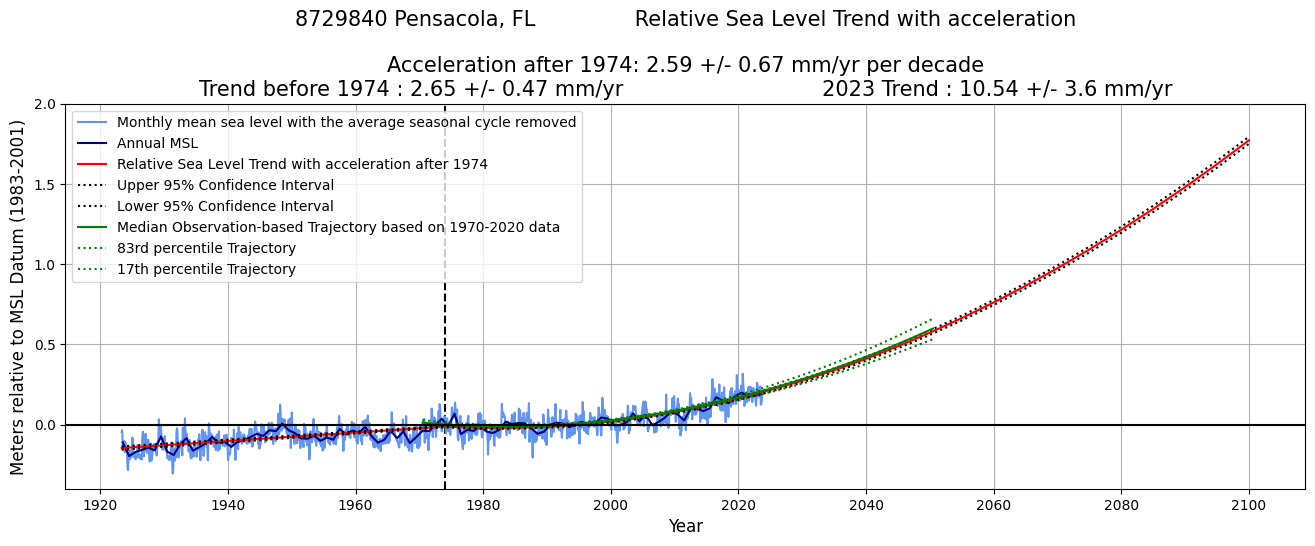

In [1126]:
# @title
if start_trend > pd.to_datetime(hinge_date):
    print("50-year Piece-wise not applicable at selected station")
elif year_start > hinge_year:
    print("50-year Piece-wise not applicable at selected station")
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=12)
    if units == 'metric':
      ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
      if station in ['8534720']:
        plt.ylim(-0.5,1.4)
      elif station in ['8557380','8594900','8638610']:
        plt.ylim(-0.4,1.4)
      elif station in ['8665530','8443970']:
        plt.ylim(-0.4,1.6)
      elif station in ['8729840','8575512','8727520']:
        plt.ylim(-0.4,2.0)
      elif station in ['8771450']:
        plt.ylim(-0.8,1.5)
      elif station in ['9451600']:
        plt.ylim(-0.8,1.2)
      else:
        plt.ylim(-0.4,1.2)
    else:
      ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
      if station in ['8534720']:
        plt.ylim(-1.65,4.6)
      elif station in ['8557380','8594900','8638610']:
        plt.ylim(-1.3,4.6)
      elif station in ['8665530','8443970']:
        plt.ylim(-1.3,5.25)
      elif station in ['8729840','8575512','8727520']:
        plt.ylim(-1.3,6.6)
      elif station in ['8771450']:
        plt.ylim(-2.62,4.9)
      elif station in ['9451600']:
        plt.ylim(-2.62,4)
      else:
        plt.ylim(-1.3,4)

    plt.axvline(x=pd.to_datetime(hinge_date),color='black',linestyle='dashed')
    plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl'],color='darkblue',label='Annual MSL')
    plt.plot(msl_adjust.index,msl_adjust['piece_trend'],label='Relative Sea Level Trend with acceleration after '+str(hinge_year),color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_piece'],label='Upper 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(msl_adjust.index,msl_adjust['lwr_piece'],label='Lower 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(median_df.index,median_df['rsl_trajectory_offset'],color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
    plt.plot(high_df.index,high_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='83rd percentile Trajectory')
    plt.plot(low_df.index,low_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='17th percentile Trajectory')
    ax.axes.grid(True)
    ax.set_title(station_info+ 15*' ' + 'Relative Sea Level Trend with acceleration\n\nAcceleration after '+str(hinge_year) +': '+accel_text2 +'\nTrend before '+str(hinge_year) +' : '+trend_text1 + 30*' '+ str(end_year_data) +' Trend : '+ trend_text2,fontsize=15)
    plt.axhline(0,color='black')
    plt.legend(loc='best')


## Did our trends change?

###*For Pensacola, a calculated trend with acceleration beginning at the year 1974 (in red) will closely follow the trajectory to 2050.  The acceleration rate beginning at 1974 (2.59 mm/yr per decade) is about six times the acceleration rate we calculated from the whole series.*

###*The trend at the year 2020 has accelerated to about 9.75 mm/yr. However, the trend right after the trend break in 1974 is actually slightly negative (-2.16 mm/yr) and much smaller than the linear trend before 1974.  The pre-1974 trend of 2.65 is very close the the CO-OPS published linear trend of 2.69 mm/yr for the entire series from 1923-2023.*

*** Note there must be at least 20 years of data before the hinge point for the hinged trend to plot.

# **Step 11**

## What trend type fits best?

###Now, we can explore some other hinged trends where the linear trend has a break point (hinge) at another selected time point.

###We will now try a break point 80 years ago (1944).

*** Note that advanced users interested in more specific hinged points can simply change 1944 to a different year of choice.

In [1127]:
#here the user can change to a different hinge year
hinge_year=1944
hinge_date = str(hinge_year) + '-01-01'
hinge_date

'1944-01-01'

In [1128]:
# @title
#For a hinged trend with acceleration, we need to adjust our input data matrix by making a time2 column that starts at the desired break point.
#The time1 column will be negative with zero at the breakpoint, and time2 column will be positive starting at the breakpoint.
# A trend2 squared column is added to solve for an acceleration parameter beginning after the break point

accel_midyear=(hinge_year+msl_adjust.index.year[-36])/2
print('accel_midyear = ',round(accel_midyear))

#create matrix for ARIMA model
matrix_data = pd.DataFrame()
matrix_data['time1']=trend_timeframe['decimal_date']
matrix_data['time1']=matrix_data['time1']- hinge_year
matrix_data['time2']=matrix_data['time1']
matrix_data.loc[matrix_data['time1']>0,'time1']=0
matrix_data.loc[matrix_data['time2']<0,'time2']=0
matrix_data['time2_sq']=matrix_data['time2']*matrix_data['time2']
matrix_data['month']=trend_timeframe.index.month
matrix_data['msl']=trend_timeframe['MSL']

matrix_data['mon1']=matrix_data['month'].apply(lambda x: 1 if x == 1 else 0)
matrix_data['mon2']=matrix_data['month'].apply(lambda x: 1 if x == 2 else 0)
matrix_data['mon3']=matrix_data['month'].apply(lambda x: 1 if x == 3 else 0)
matrix_data['mon4']=matrix_data['month'].apply(lambda x: 1 if x == 4 else 0)
matrix_data['mon5']=matrix_data['month'].apply(lambda x: 1 if x == 5 else 0)
matrix_data['mon6']=matrix_data['month'].apply(lambda x: 1 if x == 6 else 0)
matrix_data['mon7']=matrix_data['month'].apply(lambda x: 1 if x == 7 else 0)
matrix_data['mon8']=matrix_data['month'].apply(lambda x: 1 if x == 8 else 0)
matrix_data['mon9']=matrix_data['month'].apply(lambda x: 1 if x == 9 else 0)
matrix_data['mon10']=matrix_data['month'].apply(lambda x: 1 if x == 10 else 0)
matrix_data['mon11']=matrix_data['month'].apply(lambda x: 1 if x == 11 else 0)
matrix_data['mon12']=matrix_data['month'].apply(lambda x: 1 if x == 12 else 0)

matrix_data = matrix_data.drop('month',axis=1)

msl = pd.DataFrame(matrix_data['msl'])

matrix_data = matrix_data.drop('msl',axis=1)

exog=matrix_data

if units == 'metric':
  #if metric, we want results in mm instead of m
  model=ARIMA(endog=msl*1000,exog=exog,order=(1,0,0))
else:
  #if english, want in in instead of ft
  model=ARIMA(endog=msl*12,exog=exog,order=(1,0,0))
model_fit = model.fit()

print(model_fit.summary())

accel_midyear =  1984
                               SARIMAX Results                                
Dep. Variable:                    msl   No. Observations:                 1225
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6315.471
Date:                Thu, 02 May 2024   AIC                          12666.941
Time:                        16:41:11   BIC                          12758.934
Sample:                             0   HQIC                         12701.559
                               - 1225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.0730      7.562     -7.547      0.000     -71.895     -42.251
time1          5.8242      0.753      7.737      0.000       4.349       7.300
time2         -0.9789      0.4

In [1129]:
# @title
#Getting all the information from the model to plot the trendline and confidence bands
#finding the trend break
trend_break = msl_adjust.loc[msl_adjust.index==hinge_year]

coefs=model_fit.params
se=model_fit.bse

if units == 'metric':
  trend_text1=str(np.round(coefs[1],2)) +' +/- '+str(np.round(se[1]*1.96,2))+' mm/yr'
  se_accel = (se[2]**2  + (2 * (end_year_data-hinge_year)*se[3])**2)**0.5
  trend_text2=str(np.round(coefs[2] + 2*coefs[3] * (end_year_data-hinge_year),2)) +' +/- '+str(np.round(se_accel*1.96,2))+' mm/yr'
  accel_text2=str(np.round(20*coefs[3],2)) +' +/- '+str(np.round(20*se[3]*1.96,2))+' mm/yr per decade'
  const_m1 = coefs[0]/1000
  slope_m1 = coefs[1]/1000
  error_m1 = (se[1]*1.96)/1000
  slope_m2 = coefs[2]/1000
  error_m2 = (se[2]*1.96)/1000
  accel_m2 = coefs[3]/1000
  acc_error_m2 = (se[3]*1.96)/1000
else:
  trend_text1=str(np.round(10*coefs[1],2)) +' +/- '+str(np.round(10*se[1]*1.96,2))+' inches/decade'
  se_accel = (se[2]**2  + (2 * (end_year_data-hinge_year)*se[3])**2)**0.5
  trend_text2=str(np.round(10*coefs[2] + 20*coefs[3] * (end_year_data-hinge_year),2)) +' +/- '+str(np.round(10*se_accel*1.96,2))+' inches/decade'
  accel_text2=str(np.round(200*coefs[3],2)) +' +/- '+str(np.round(200*se[3]*1.96,2))+' inches/decade per decade'
  const_m1 = coefs[0]/12
  slope_m1 = coefs[1]/12
  error_m1 = (se[1]*1.96)/12
  slope_m2 = coefs[2]/12
  error_m2 = (se[2]*1.96)/12
  accel_m2 = coefs[3]/12
  acc_error_m2 = (se[3]*1.96)/12

print(bold('Trend before '+ str(hinge_year) +'  '+ trend_text1))
print(bold(str(end_year_data) + ' Trend : ' + trend_text2))
print(bold('Acceleration ' + accel_text2))
print(bold('Constant Acceleration since '+ str(np.datetime64(hinge_date,'Y'))))

#grabbing the months result from arima model
seasonal = coefs[2:14]
#calculating the mean seasonal and adding it to the trend line
seasonal = np.mean(seasonal)/1000

year_start = msl_adjust['decimal_date'].iloc[0]

lin_y_int1 = getYInt(hinge_year,0,slope_m1,0)

msl_adjust['piece_trend'] = slope_m1*(msl_adjust['decimal_date']-hinge_year) + const_m1
msl_adjust['piece_trend'] = msl_adjust['piece_trend']+seasonal

trend_break = msl_adjust.loc[msl_adjust.index==hinge_date]

if len(trend_break) == 0:
    trend_break=msl_adjust[msl_adjust.index>hinge_date].head(1)

lin_y_int2 = getYInt(0,trend_break['piece_trend'].values[0],slope_m2,accel_m2)

#changing our trend slope at the hinge_date
msl_adjust.loc[msl_adjust.index>= hinge_date,'piece_trend']=accel_m2*(msl_adjust['decimal_date']-hinge_year)*(msl_adjust['decimal_date']-hinge_year) + slope_m2*(msl_adjust['decimal_date']-hinge_year)+lin_y_int2


Trend before 1944  5.82 +/- 1.48 mm/yr
2023 Trend : 6.62 +/- 2.1 mm/yr
Acceleration 0.96 +/- 0.24 mm/yr per decade
Constant Acceleration since 1944


In [1130]:
# @title
#manually calculate se of estimate
msl_adjust['y_y2']=(msl_adjust['msl_seasonal_adjust']-msl_adjust['piece_trend'])**2
y_y2_sum = msl_adjust['y_y2'].sum()
msl_adjust['se_regression']=np.sqrt(y_y2_sum/(len(msl_adjust)-2))
se_regression=np.sqrt(y_y2_sum/(len(msl_adjust)-2))

#calculate standard error of the regession line at each point
one_over_n = 1/len(msl_adjust)
msl_adjust['x_x2'] = (msl_adjust['piece_trend']-msl_adjust['piece_trend'].mean())**2
msl_adjust['sum_x_x2'] = msl_adjust['x_x2'].sum()
sum_x_x2=msl_adjust['x_x2'].sum()
msl_adjust['sqrt'] = np.sqrt(one_over_n+(msl_adjust['x_x2']/msl_adjust['sum_x_x2']))
msl_adjust['se_point'] = (msl_adjust['se_regression'])*msl_adjust['sqrt']

p1 = coefs[-2]
VIF = ((1 + p1) / (1 - p1)) ** 0.5
# Calculate standard error of the regression line at each point
msl_adjust['se_point_vif'] = msl_adjust['se_point'] * VIF

#confidence bands
msl_adjust['upr_piece'] = msl_adjust['piece_trend']+1.96*msl_adjust['se_point_vif']
msl_adjust['lwr_piece'] = msl_adjust['piece_trend']-1.96*msl_adjust['se_point_vif']

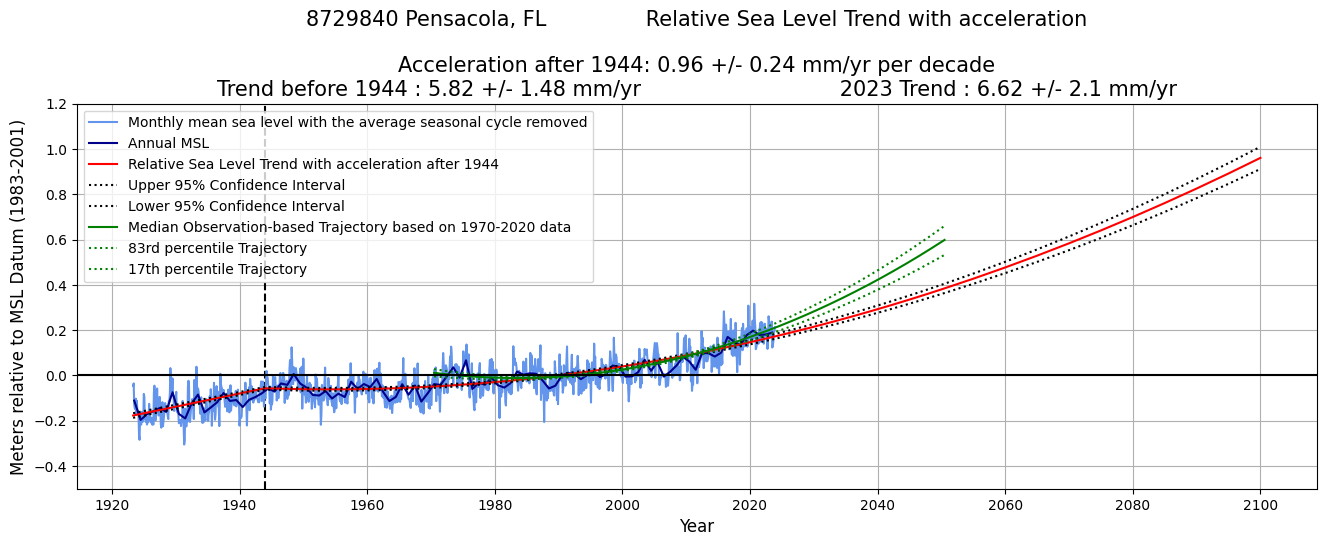

In [1131]:
# @title
if start_trend > pd.to_datetime(hinge_date):
    print("50-year Piece-wise not applicable at selected station")
elif year_start > hinge_year:
    print("50-year Piece-wise not applicable at selected station")
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=12)
    if units == 'metric':
      ax.set_ylabel("Meters relative to MSL Datum ("+epoch_info+')',fontsize=12)
      if station in ['8771450','9451600']:
        plt.ylim(-0.8,1.2)
      else:
        plt.ylim(-0.5,1.2)
    else:
      ax.set_ylabel("Feet relative to MSL Datum ("+epoch_info+')',fontsize=12)
      if station in ['8771450','9451600']:
        plt.ylim(-2.6,4)
      else:
        plt.ylim(-1.6,4)
    plt.axvline(x=pd.to_datetime(hinge_date),color='black',linestyle='dashed')
    plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"],label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl'],color='darkblue',label='Annual MSL')
    plt.plot(msl_adjust.index,msl_adjust['piece_trend'],label='Relative Sea Level Trend with acceleration after '+str(hinge_year),color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_piece'],label='Upper 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(msl_adjust.index,msl_adjust['lwr_piece'],label='Lower 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(median_df.index,median_df['rsl_trajectory_offset'],color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
    plt.plot(high_df.index,high_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='83rd percentile Trajectory')
    plt.plot(low_df.index,low_df['rsl_trajectory_offset'],color='green',linestyle='dotted',label='17th percentile Trajectory')
    ax.axes.grid(True)
    ax.set_title(station_info+ 15*' ' + 'Relative Sea Level Trend with acceleration\n\nAcceleration after '+str(hinge_year) +': '+accel_text2 +'\nTrend before '+str(hinge_year) +' : '+trend_text1 + 30*' '+ str(end_year_data) +' Trend : '+ trend_text2,fontsize=15)
    plt.axhline(0,color='black')
    plt.legend(loc='best')


## Did our trends change?

###*For Pensacola, a calculated trend with acceleration beginning in the year 1944 does not follow the trajectory to 2050.  The acceleration rate beginning in 1944 (0.96 mm/yr per decade) is less than half of an acceleration rate beginning in 1974.*

###*The trend at the year 2020 has accelerated to 6.31 +/- 0.96 mm/yr. This can be compared to the trend of 9.75 +/- 1.54 in the previous example.  This model reaches the 2050 level of the trajectory sometime after 2070. *

*** Note there must be at least 20 years of data before the hinge point for the hinged trend to plot.

# **Step 12**
# Incorporating future SL scenario-based projections.

## First, we will plot the 2022 technical report's projections for each of the 5 SLR scenarios and compare them with the annually-averaged MSL series.  The projections begin in the year 2005 at a level of zero.  The annual MSL series can be shifted to center at 2005 by creating a 1996-2014 MSL baseline level.

In [1132]:
# @title
epoch_96_14=msl_adjust['1996':'2014']
epoch_offset_2005=np.nanmean(epoch_96_14['msl_seasonal_adjust'])

if units == 'metric':
  print(bold('offset_2005 to set the 1996-2014 MSL data to be zero at 2005 : ' + str(round(-epoch_offset_2005,3)) + '   meters'))
else:
  print(bold('offset_2005 to set the 1996-2014 MSL data to be zero at 2005 : ' + str(round(-epoch_offset_2005,2)) + '   feet'))

if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540']:
    print('This station does not have regional scenarios. Please choose another station to proceed through the notebook.')

else:
# Get SLR Projections from 2022 Tech Report
    product = "slr_projections"

    server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/"
    #eg: https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/slr_projections.json?units=metric&station=8638610&&report_year=2022&affil=us

    affil = "US"

    report_year='2022'

    myurl=(server+ product  + ".json?"+"units="+units+"&station=" + station + "&report_year=" + report_year+"&affil=" + affil)
    # Use requests to get the data
    urlResponse = requests.get(myurl)
    content=urlResponse.json()

    # Assign data to variables
    mydata = content['SlrProjections']

    # Make it a Dataframe
    mydf_slr_projection = pd.DataFrame(mydata)
    mydf_slr_projection['day'] = '01'
    mydf_slr_projection['month'] = '01'
    mydf_slr_projection['year_date'] = pd.to_datetime(dict(year=mydf_slr_projection.projectionYear,month=mydf_slr_projection.month,day=mydf_slr_projection.day))
    mydf_slr_projection=mydf_slr_projection[mydf_slr_projection['year_date']<'2061-01-01']

    if units == 'metric':
      #converting from cm to m
      mydf_slr_projection['projectionRsl']=mydf_slr_projection['projectionRsl']*0.01
    else:
      #converting from in to ft
      mydf_slr_projection['projectionRsl']=mydf_slr_projection['projectionRsl']*0.0833333

    mydf_slr_projection['projectionRsl'] = mydf_slr_projection['projectionRsl']

    # Break down SLR Projections by Scenario
    scenario_low=mydf_slr_projection[mydf_slr_projection['scenario']=='Low']
    scenario_low.reset_index(inplace=True,drop=True)
    scenario_intlow=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-Low']
    scenario_intlow.reset_index(inplace=True,drop=True)
    scenario_int=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate']
    scenario_int.reset_index(inplace=True,drop=True)
    scenario_inthigh=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-High']
    scenario_inthigh.reset_index(inplace=True,drop=True)
    scenario_high=mydf_slr_projection[mydf_slr_projection['scenario']=='High']
    scenario_high.reset_index(inplace=True,drop=True)

offset_2005 to set the 1996-2014 MSL data to be zero at 2005 : -0.038   meters


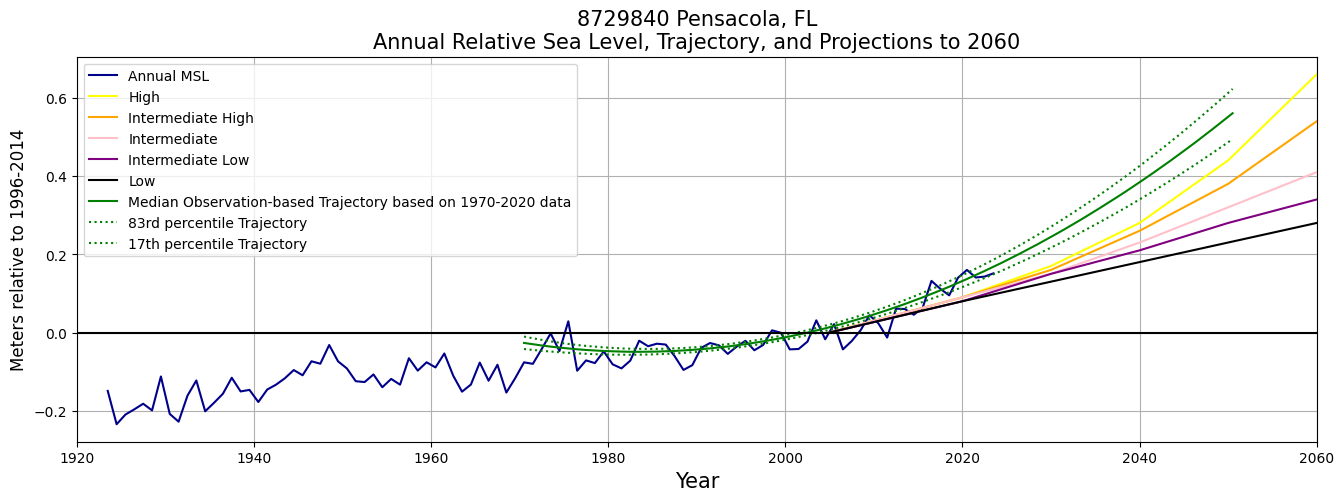

In [1133]:
# @title
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540','2695540']:
    print('This station does not have regional scenarios. Please choose another station to proceed through the notebook.')
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=15)
    ax.set_xlim(pd.to_datetime('1920-01-01'),pd.to_datetime('2060-01-01'))
    if units == 'metric':
      ax.set_ylabel("Meters relative to 1996-2014",fontsize=12)
    else:
      ax.set_ylabel("Feet relative to 1996-2014",fontsize=12)

    plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl']-epoch_offset_2005,color='darkblue',label='Annual MSL')
    plt.plot(scenario_high.year_date,scenario_high['projectionRsl'],label='High',color='yellow')
    plt.plot(scenario_inthigh.year_date,scenario_inthigh['projectionRsl'],label='Intermediate High',color='orange')
    plt.plot(scenario_int.year_date,scenario_int['projectionRsl'],label='Intermediate',color='pink')
    plt.plot(scenario_intlow.year_date,scenario_intlow['projectionRsl'],label='Intermediate Low',color='purple')
    plt.plot(scenario_low.year_date,scenario_low['projectionRsl'],label='Low',color='black')
    plt.plot(median_df.index,median_df['rsl_trajectory_offset']-epoch_offset_2005,color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
    plt.plot(high_df.index,high_df['rsl_trajectory_offset']-epoch_offset_2005,color='green',linestyle='dotted',label='83rd percentile Trajectory')
    plt.plot(low_df.index,low_df['rsl_trajectory_offset']-epoch_offset_2005,color='green',linestyle='dotted',label='17th percentile Trajectory')
    ax.axes.grid(True)
    ax.set_title(station_info + "\nAnnual Relative Sea Level, Trajectory, and Projections to 2060",fontsize=15)
    plt.axhline(0,color='black')
    plt.legend(loc='best')

###*For Pensacola, it can be seen that the 4 annual MSLs from 1972 to 1975 and the 5 annual MSLs from 2016 to 2020 have sharply increased the curvature of the trajectory and the sea level reached by 2050 is far above any of the 5 projections from the 2022 Sea Level Rise Technical Report.*


## Next, lets shift the data, the trajectory, the projections, and the calculated trend with acceleration to center on the level of the data at year 2020 .  This will enable us to see how much relative sea level change to expect between 2020 and 2050.  The trajectory forecasts over 0.4 meters rise for that period

now set the 2016-2024 MSL data to be zero at 2020 with an offset of : -0.172   meters which will then be applied to all the other series


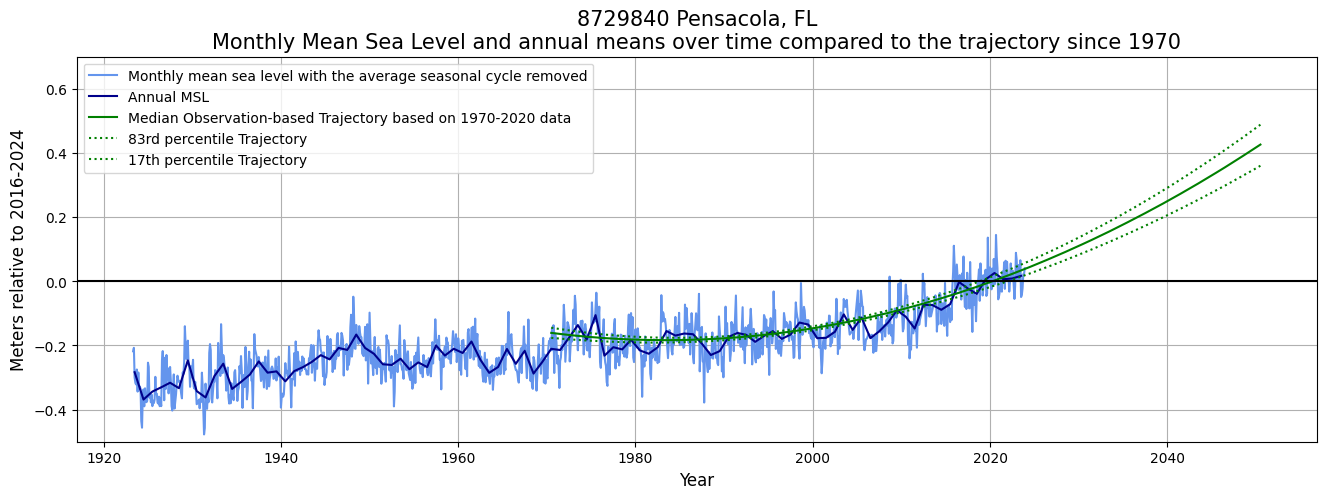

In [1134]:
# @title
epoch_16_24=msl_adjust['2016':'2024']
epoch_offset_2020=np.nanmean(epoch_16_24['msl_seasonal_adjust'])
fig, ax=plt.subplots(figsize=(16,5))
if units == 'metric':
  print(bold('now set the 2016-2024 MSL data to be zero at 2020 with an offset of : ' + str(round(-epoch_offset_2020,3)) + '   meters which will then be applied to all the other series'))
  if station in ['8594900','8727520','8729840']:
    plt.ylim(-0.5,0.7)
  elif station in ['8771450']:
      plt.ylim(-1,0.6)
  else:
      plt.ylim(-0.6,0.6)
else:
  print(bold('now set the 2016-2024 MSL data to be zero at 2020 with an offset of : ' + str(round(-epoch_offset_2020,2)) + '   feet which will then be applied to all the other series'))
  if station in ['8594900','8727520','8729840']:
    plt.ylim(-1.6,2.3)
  elif station in ['8771450']:
      plt.ylim(-3.3,2)
  else:
      plt.ylim(-2,2)

ax.set_xlabel("Year",fontsize=12)
if units == 'metric':
  ax.set_ylabel("Meters relative to 2016-2024",fontsize=12)
else:
  ax.set_ylabel("Feet relative to 2016-2024",fontsize=12)
ax.set_title(station_info + "\nMonthly Mean Sea Level and annual means over time compared to the trajectory since 1970",fontsize=15)
ax.axes.grid(True)
plt.plot(msl_adjust['msl_seasonal_adjust']-epoch_offset_2020,label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
plt.plot(msl_adjust['year_date'],msl_adjust['annual_msl']-epoch_offset_2020,color='darkblue',label='Annual MSL')
plt.plot(median_df.index,median_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
plt.plot(high_df.index,high_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='83rd percentile Trajectory')
plt.plot(low_df.index,low_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='17th percentile Trajectory')
plt.axhline(0,color='black')
plt.legend(loc='best')


## Let's also incorporate the background relative sea level from the 2022 SLR report
### We can use the background relative sea level (RSL) to examine the contribution of Vertical Land Motion to relative sea level change since the start of observations.

### Tide gauge trends are relative to a fixed point on land and reflect both the changes in water level and local VLM. VLM can vary due to different factors such glacial rebound, earthquakes, and ground-water withdrawal. A positive background sea level trend indicates that the land is sinking, thus contributing positively to sea level rise. A negative background sea level trend means the land is rising, thus contributing negatively to sea level rise.

In [1135]:
# @title
if station in ['9463502','9437540','8737048','8726384','8726674','8729210','8761927','8772447','8778490','8779748','8570283',
               '8573927','8631044','8635027','8637689','8419870','8423898','2695540']:
  print('This station does not have background SL data. Please choose another station to proceed through the notebook.')
else:
  if units == 'metric':
    #all we have is the trend slope in cm/year
    rsl = mydf_slr_projection['backgroundRslPerYear'][0] * 0.01
    rsl_mm = mydf_slr_projection['backgroundRslPerYear'][0] * 10
    rsl_text=str(np.round(rsl_mm,2))+' mm/yr'
  else:
    rsl = mydf_slr_projection['backgroundRslPerYear'][0] * 0.0833333
    rsl_mm = mydf_slr_projection['backgroundRslPerYear'][0]
    rsl_text=str(np.round(10*rsl_mm,2))+' inches/decade'

  lin_trend = msl_adjust['piece_trend'].iloc[0]
  year_start = trend_timeframe['decimal_date'].iloc[0]

  y_int = getYInt(year_start,lin_trend,rsl,0)
  msl_adjust['backgroundRsl']= rsl*trend_timeframe['decimal_date']+y_int

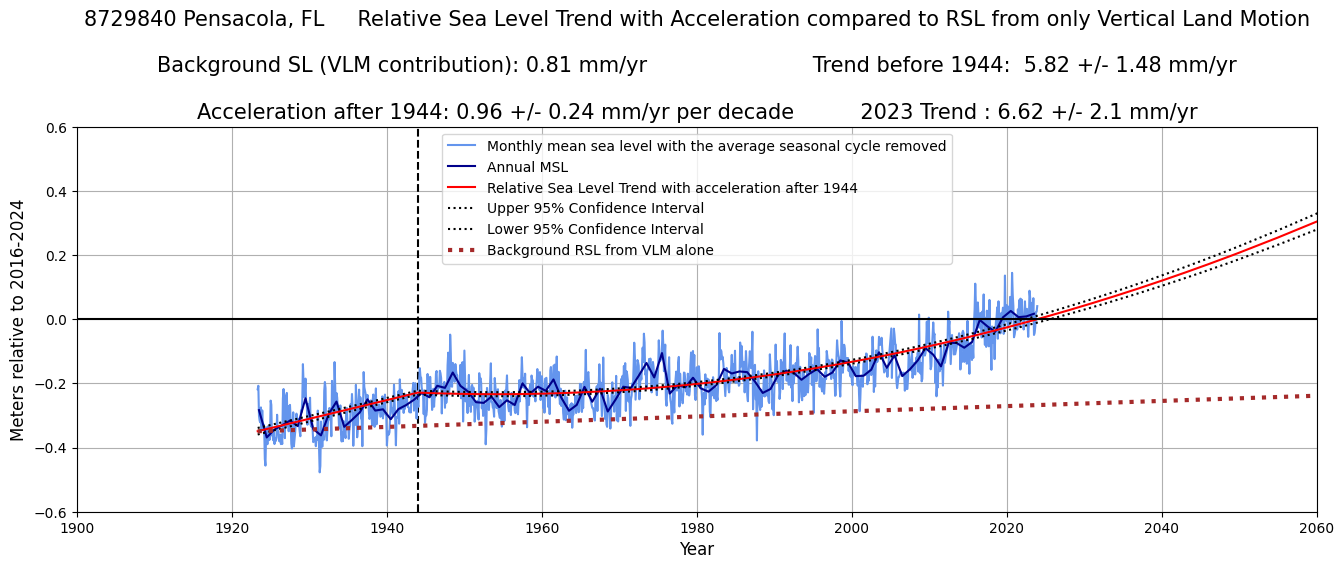

In [1136]:
# @title
if start_trend > pd.to_datetime(hinge_date):
    print("50-year Piece-wise not applicable at selected station")
elif year_start > hinge_year:
    print("50-year Piece-wise not applicable at selected station")
else:
    fig, ax=plt.subplots(figsize=(16,5))
    ax.set_xlabel("Year",fontsize=12)
    ax.set_xlim(pd.to_datetime('1900-01-01'),pd.to_datetime('2060-01-01'))
    if units == 'metric':
      ax.set_ylabel("Meters relative to 2016-2024",fontsize=12)
      if station in ['8771450']:
        plt.ylim(-1,0.6)
      else:
        plt.ylim(-0.6,0.6)
    else:
      ax.set_ylabel("Feet relative to 2016-2024",fontsize=12)
      if station in ['8771450']:
        plt.ylim(-3.3,2)
      else:
        plt.ylim(-2,2)
    plt.axvline(x=pd.to_datetime(hinge_date),color='black',linestyle='dashed')
    plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"]-epoch_offset_2020,label='Monthly mean sea level with the average seasonal cycle removed',color='cornflowerblue')
    plt.plot(msl_adjust.year_date,msl_adjust['annual_msl']-epoch_offset_2020,color='darkblue',label='Annual MSL')
    plt.plot(msl_adjust.index,msl_adjust['piece_trend']-epoch_offset_2020,label='Relative Sea Level Trend with acceleration after '+str(hinge_year),color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_piece']-epoch_offset_2020,label='Upper 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(msl_adjust.index,msl_adjust['lwr_piece']-epoch_offset_2020,label='Lower 95% Confidence Interval',color='black',linestyle='dotted')
    #plt.plot(median_df.index,median_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',label='Median Observation-based Trajectory based on 1970-2020 data')
    #plt.plot(high_df.index,high_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='83rd percentile Trajectory')
    #plt.plot(low_df.index,low_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='17th percentile Trajectory')
    plt.plot(msl_adjust.index,msl_adjust['backgroundRsl']-epoch_offset_2020,color='brown',linestyle='dotted',linewidth='3',label='Background RSL from VLM alone')
    ax.axes.grid(True)
    ax.set_title(station_info +5*' ' +"Relative Sea Level Trend with Acceleration compared to RSL from only Vertical Land Motion" +'\n\n'+'Background SL (VLM contribution): ' + rsl_text +25*' '  +'Trend before '+str(hinge_year) +':  '+trend_text1+ '\n\nAcceleration after '+str(hinge_year) +': '+accel_text2 + 10*' ' + str(end_year_data) +' Trend : '+trend_text2,fontsize=15)
    plt.axhline(0,color='black')
    plt.legend(loc='best')


## Now, we can plot everything together!

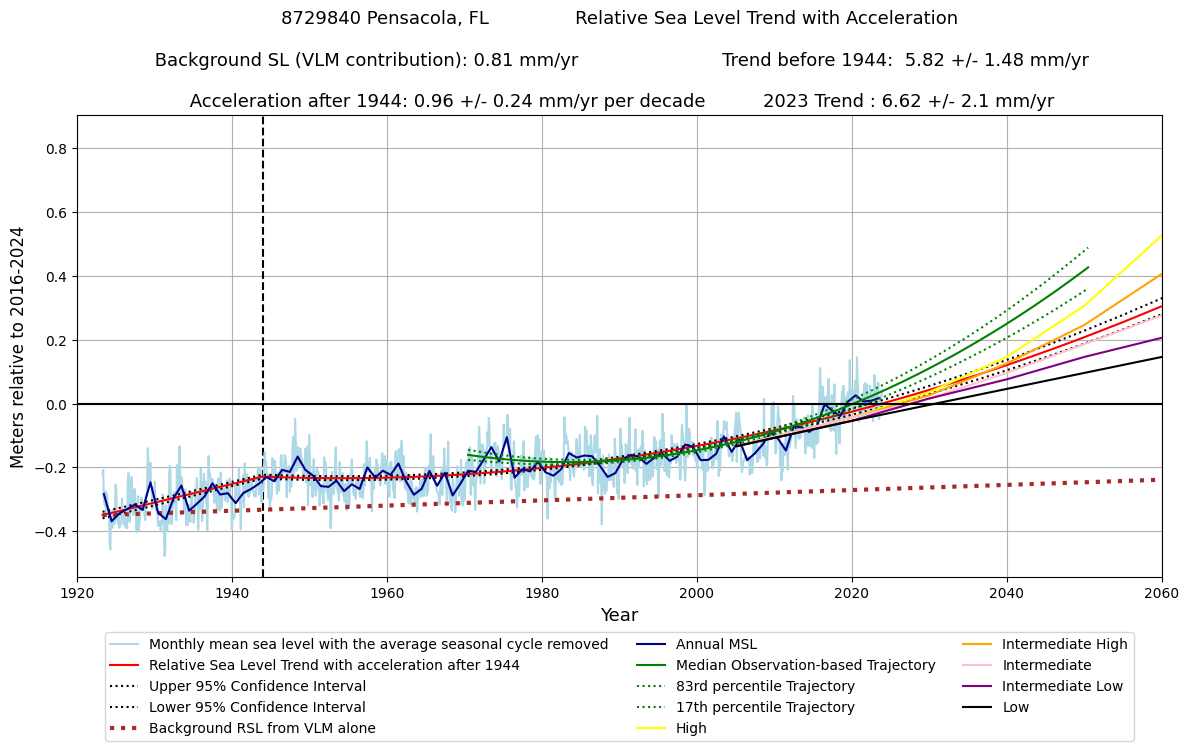

In [1137]:
# @title
if station in ['9463502','9437540','8737048','8726384','8729210','8761927','8772447','8778490','8779748','8570283','8573927',
              '8631044','8635027','8637689','8419870','8423898','2695540','9414523','9418767','8726384','8761927','8771510','8772447','8778490','8779748','8570283','8573927','8635027',
                '8411250','8419870','2695540','9455090']:
    print('This station does not have trajectories and/or regional scenarios. Please choose another station to proceed through the notebook.')
else:
    fig, ax=plt.subplots(figsize=(14,6))
    ax.set_xlabel("Year",fontsize=13)
    ax.set_xlim(pd.to_datetime('1920-01-01'),pd.to_datetime('2060-01-01'))
    if units == 'metric':
      ax.set_ylabel("Meters relative to 2016-2024",fontsize=12)
    else:
      ax.set_ylabel("Feet relative to 2016-2024",fontsize=12)
    plt.axvline(x=pd.to_datetime(hinge_date),color='black',linestyle='dashed')
    plt.plot(msl_adjust.index,msl_adjust["msl_seasonal_adjust"]-epoch_offset_2020,label='Monthly mean sea level with the average seasonal cycle removed',color='lightblue')
    plt.plot(msl_adjust.index,msl_adjust['piece_trend']-epoch_offset_2020,label='Relative Sea Level Trend with acceleration after '+str(hinge_year),color='red')
    plt.plot(msl_adjust.index,msl_adjust['upr_piece']-epoch_offset_2020,label='Upper 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(msl_adjust.index,msl_adjust['lwr_piece']-epoch_offset_2020,label='Lower 95% Confidence Interval',color='black',linestyle='dotted')
    plt.plot(msl_adjust.index,msl_adjust['backgroundRsl']-epoch_offset_2020,color='brown',linestyle='dotted',linewidth='3',label='Background RSL from VLM alone')
    plt.plot(msl_adjust.year_date,msl_adjust['annual_msl']-epoch_offset_2020,color='darkblue',label='Annual MSL')
    plt.plot(median_df.index,median_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',label='Median Observation-based Trajectory')
    plt.plot(high_df.index,high_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='83rd percentile Trajectory')
    plt.plot(low_df.index,low_df['rsl_trajectory_offset']-epoch_offset_2020,color='green',linestyle='dotted',label='17th percentile Trajectory')
    plt.plot(scenario_high.year_date,scenario_high['projectionRsl']+epoch_offset_2005-epoch_offset_2020,label='High',color='yellow')
    plt.plot(scenario_inthigh.year_date,scenario_inthigh['projectionRsl']+epoch_offset_2005-epoch_offset_2020,label='Intermediate High',color='orange')
    plt.plot(scenario_int.year_date,scenario_int['projectionRsl']+epoch_offset_2005-epoch_offset_2020,label='Intermediate',color='pink')
    plt.plot(scenario_intlow.year_date,scenario_intlow['projectionRsl']+epoch_offset_2005-epoch_offset_2020,label='Intermediate Low',color='purple')
    plt.plot(scenario_low.year_date,scenario_low['projectionRsl']+epoch_offset_2005-epoch_offset_2020,label='Low',color='black')
    ax.axes.grid(True)
    ax.set_title(station_info + 15*' '+"Relative Sea Level Trend with Acceleration\n\n Background SL (VLM contribution): " + rsl_text + 25*' ' + 'Trend before '+str(hinge_year) +':  '+trend_text1+ '\n\n Acceleration after '+str(hinge_year) +': '+accel_text2+ 10*' '+ str(end_year_data) +' Trend : '+ trend_text2,fontsize=13)
    plt.axhline(0,color='black')
    plt.legend(bbox_to_anchor=(0.5,-0.37),loc='lower center',ncol=3,fontsize=10)

## **Takeaways**

###Thank you for taking the time to walk through this Sea Level Acceleration Exploration notebook.

###Some key takeaways include:

*   How to access CO-OPS data from the CO-OPS API (here is a [URL builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html) if you want to explore other CO-OPS data)
*   Understanding different station's seasonal cycles and how they have changed over time

*   How to run ARIMA models to get SL trends
*   How hinged trends with a quadratic term can provide information about SL accelerations calculated over different time periods
*   How to plot data from the 2022 Sea Level Report with CO-OPS sea level data to gain better understanding of how sea level could change in the future



